# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Campo 100 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')

In [6]:
np.shape(campvectrain)

(7000, 2, 100, 100)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')

In [10]:
np.shape(campvectest)

(2000, 2, 100, 100)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')

In [14]:
np.shape(campvecval)

(1000, 2, 100, 100)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(2, 100, 100), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creamos función de costo

In [20]:
def custom_loss(y_true, y_pred):
    campvec = []
    # constantes
    a1 = tf.cast(y_true[:, 0], tf.float64)
    #tf.print(a1)
    a1 = tf.reshape(a1, shape=(-1, 1, 1))

    a2 = tf.cast(y_true[:, 1], tf.float64)
    a2 = tf.reshape(a2, shape=(-1, 1, 1))
    
    b1 = tf.cast(y_true[:, 2], tf.float64)
    b1 = tf.reshape(b1,shape = (-1,1,1))
    
    b2 = tf.cast(y_true[:, 3], tf.float64)
    b2 = tf.reshape(b2,shape = (-1,1,1))

    d1 = tf.cast(y_true[:, 4], tf.float64)
    d1 = tf.reshape(d1, shape=(-1, 1, 1))

    d2 = tf.cast(y_true[:, 5], tf.float64)
    d2 = tf.reshape(d2, shape=(-1, 1, 1))

    n = tf.cast(y_true[:, 6], tf.float64)
    n = tf.reshape(n, shape=(-1, 1, 1))

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        X = tf.cast(X, tf.float64)
        X = tf.reshape(X, shape=(1, 100,100))
        Y = y[1]
        Y = tf.cast(Y, tf.float64)
        Y = tf.reshape(Y, shape=(1, 100,100))
        
        # definimos cada ODE
        dX_dt = tf.divide(a1,(1 + tf.math.pow(Y, n)+1e-5)) - tf.multiply(d1,X) + b1
        dY_dt = tf.divide(a2,(1 + tf.math.pow(X, n)+1e-7)) - tf.multiply(d2,Y) + b2
        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 20
    y_range_neg = 0
    y_range_pos = 20
    y1 = tf.linspace(x_range_neg, x_range_pos, 100)
    y2 = tf.linspace(y_range_neg, y_range_pos, 100)
    Y1, Y2 = tf.meshgrid(y1, y2)
    t = 0
    u, v = tf.zeros(Y1.shape), tf.zeros(Y2.shape)
    u, v = f(t, [Y1, Y2])
    #M = tf.sqrt(tf.square(u) + tf.square(v))
    #u /= M
    #v /= M
# ----------------------------------------------------------------------------
    campvec2 = []
    # constantes
    a12 = tf.cast(y_pred[:, 0], tf.float64)
    a12 = tf.reshape(a12, shape=(-1, 1, 1))

    a22 = tf.cast(y_pred[:, 1], tf.float64)
    a22 = tf.reshape(a22, shape=(-1, 1, 1))
    
    b12 = tf.cast(y_pred[:, 2], tf.float64)
    b12 = tf.reshape(b12,shape = (-1,1,1))
    
    b22 = tf.cast(y_pred[:, 3], tf.float64)
    b22 = tf.reshape(b22,shape = (-1,1,1))

    d12 = tf.cast(y_pred[:, 4], tf.float64)
    d12 = tf.reshape(d12, shape=(-1, 1, 1))

    d22 = tf.cast(y_pred[:, 5], tf.float64)
    d22 = tf.reshape(d22, shape=(-1, 1, 1))

    n2 = tf.cast(y_pred[:, 6], tf.float64)
    n2 = tf.reshape(n2, shape=(-1, 1, 1))
    
    def f2(t2, ye2):

        # asignar a cada ODE a un elemento de vector
        X2 = ye2[0]
        X2 = tf.cast(X2, tf.float64)
        X2 = tf.reshape(X2, shape=(1, 100,100))
        Y2 = ye2[1]
        Y2 = tf.cast(Y2, tf.float64)
        Y2 = tf.reshape(Y2, shape=(1, 100,100))

        # definimos cada ODE
        dX2_dt = tf.divide(a12,(1 + tf.math.pow(Y2, n2)+1e-8)) - tf.multiply(d12,X2) + b12
        dY2_dt = tf.divide(a22,(1 + tf.math.pow(X2, n2)+1e-8)) - tf.multiply(d22,Y2) + b22
        return [dX2_dt, dY2_dt]

    y12 = tf.linspace(x_range_neg, x_range_pos, 100)
    y22 = tf.linspace(y_range_neg, y_range_pos, 100)
    Y12, Y22 = tf.meshgrid(y12, y22)
    u2, v2 = tf.zeros(Y12.shape), tf.zeros(Y22.shape)
    u2, v2 = f2(t, [Y12, Y22])
    #M2 = tf.sqrt(tf.square(u2) + tf.square(v2))
    #u2 /= M2
    #v2 /= M2
    campvecx = tf.abs(tf.subtract(u,u2))
    campvecy = tf.abs(tf.subtract(v,v2))
    campvec_magnitude = tf.add(campvecx,campvecy)
    loss = tf.reduce_mean(campvec_magnitude)
    #tf.print(y_pred)
    return loss

# Creación del modelo

In [21]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [22]:

model = Sequential()
model.add(Flatten(input_shape=(2,100,100)))
model.add(BatchNormalization())
model.add(Dense(128,activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(128,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(128,activation = 'tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64,activation = 'tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))

model.add(Dense(7, activation= custom_activation))

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(2,100,100)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation = custom_activation)
])


In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 20000)             0         
                                                                 
 batch_normalization_1 (Batc  (None, 20000)            80000     
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 128)               2560128   
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 128)               8320      
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                      

In [25]:
keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Entrenamos el modelo

In [26]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [27]:
model.compile(optimizer=optimizer,
              loss= custom_loss,
              metrics=['accuracy'])


In [28]:
def scheduler(epoch, lr):
  if epoch < 100:
    return lr
  else:
    return 1e-3 -  9.9e-6** epoch

In [30]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 800,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
700/700 [==============================] - 8s 11ms/step - loss: 19.7760 - accuracy: 0.2957 - val_loss: 7.4974 - val_accuracy: 0.3200 - lr: 0.0010
Epoch 2/1000
700/700 [==============================] - 8s 12ms/step - loss: 19.6123 - accuracy: 0.3030 - val_loss: 7.7020 - val_accuracy: 0.3370 - lr: 0.0010
Epoch 3/1000
700/700 [==============================] - 8s 12ms/step - loss: 18.9939 - accuracy: 0.2956 - val_loss: 6.4168 - val_accuracy: 0.3450 - lr: 0.0010
Epoch 4/1000
700/700 [==============================] - 8s 12ms/step - loss: 19.3540 - accuracy: 0.3211 - val_loss: 7.8651 - val_accuracy: 0.3440 - lr: 0.0010
Epoch 5/1000
700/700 [==============================] - 8s 12ms/step - loss: 19.1322 - accuracy: 0.3230 - val_loss: 6.9533 - val_accuracy: 0.3560 - lr: 0.0010
Epoch 6/1000
700/700 [==============================] - 8s 12ms/step - loss: 18.8780 - accuracy: 0.3299 - val_loss: 8.0828 - val_accuracy: 0.3240 - lr: 0.0010
Epoch 7/1000
700/700 [========================

700/700 [==============================] - 8s 11ms/step - loss: 16.9448 - accuracy: 0.3646 - val_loss: 12.5204 - val_accuracy: 0.4020 - lr: 0.0010
Epoch 53/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.7605 - accuracy: 0.3673 - val_loss: 14.4763 - val_accuracy: 0.3980 - lr: 0.0010
Epoch 54/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.8829 - accuracy: 0.3599 - val_loss: 13.8046 - val_accuracy: 0.3940 - lr: 0.0010
Epoch 55/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.7376 - accuracy: 0.3569 - val_loss: 15.1938 - val_accuracy: 0.3850 - lr: 0.0010
Epoch 56/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.5628 - accuracy: 0.3694 - val_loss: 11.7737 - val_accuracy: 0.3990 - lr: 0.0010
Epoch 57/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.9051 - accuracy: 0.3713 - val_loss: 13.2847 - val_accuracy: 0.4100 - lr: 0.0010
Epoch 58/1000
700/700 [=========================

Epoch 103/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.9361 - accuracy: 0.3680 - val_loss: 14.2456 - val_accuracy: 0.3890 - lr: 0.0010
Epoch 104/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.5309 - accuracy: 0.3690 - val_loss: 14.7734 - val_accuracy: 0.4050 - lr: 0.0010
Epoch 105/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.8533 - accuracy: 0.3604 - val_loss: 13.6329 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 106/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.9176 - accuracy: 0.3650 - val_loss: 15.1774 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 107/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.8088 - accuracy: 0.3530 - val_loss: 15.6610 - val_accuracy: 0.3980 - lr: 0.0010
Epoch 108/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.7392 - accuracy: 0.3591 - val_loss: 15.7857 - val_accuracy: 0.3950 - lr: 0.0010
Epoch 109/1000
700/700 [====

Epoch 204/1000
700/700 [==============================] - 7s 10ms/step - loss: 16.7830 - accuracy: 0.3506 - val_loss: 16.8783 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 205/1000
700/700 [==============================] - 7s 10ms/step - loss: 16.7059 - accuracy: 0.3586 - val_loss: 17.3176 - val_accuracy: 0.4050 - lr: 0.0010
Epoch 206/1000
700/700 [==============================] - 7s 10ms/step - loss: 16.6706 - accuracy: 0.3540 - val_loss: 16.2255 - val_accuracy: 0.4150 - lr: 0.0010
Epoch 207/1000
700/700 [==============================] - 7s 10ms/step - loss: 16.5770 - accuracy: 0.3514 - val_loss: 16.7494 - val_accuracy: 0.3960 - lr: 0.0010
Epoch 208/1000
700/700 [==============================] - 7s 10ms/step - loss: 16.5802 - accuracy: 0.3469 - val_loss: 17.2841 - val_accuracy: 0.4080 - lr: 0.0010
Epoch 209/1000
700/700 [==============================] - 7s 10ms/step - loss: 16.4129 - accuracy: 0.3533 - val_loss: 18.3304 - val_accuracy: 0.3940 - lr: 0.0010
Epoch 210/1000
700/700 [====

Epoch 305/1000
700/700 [==============================] - 8s 12ms/step - loss: 16.8415 - accuracy: 0.3511 - val_loss: 16.6384 - val_accuracy: 0.4090 - lr: 0.0010
Epoch 306/1000
700/700 [==============================] - 8s 12ms/step - loss: 16.5992 - accuracy: 0.3530 - val_loss: 17.6900 - val_accuracy: 0.4090 - lr: 0.0010
Epoch 307/1000
700/700 [==============================] - 8s 12ms/step - loss: 16.8223 - accuracy: 0.3501 - val_loss: 16.4522 - val_accuracy: 0.4150 - lr: 0.0010
Epoch 308/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.5259 - accuracy: 0.3504 - val_loss: 18.6873 - val_accuracy: 0.4240 - lr: 0.0010
Epoch 309/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.6665 - accuracy: 0.3459 - val_loss: 17.1746 - val_accuracy: 0.4170 - lr: 0.0010
Epoch 310/1000
700/700 [==============================] - 8s 11ms/step - loss: 16.7400 - accuracy: 0.3476 - val_loss: 18.5057 - val_accuracy: 0.4170 - lr: 0.0010
Epoch 311/1000
700/700 [====

KeyboardInterrupt: 

# Analizamos accuracy y loss

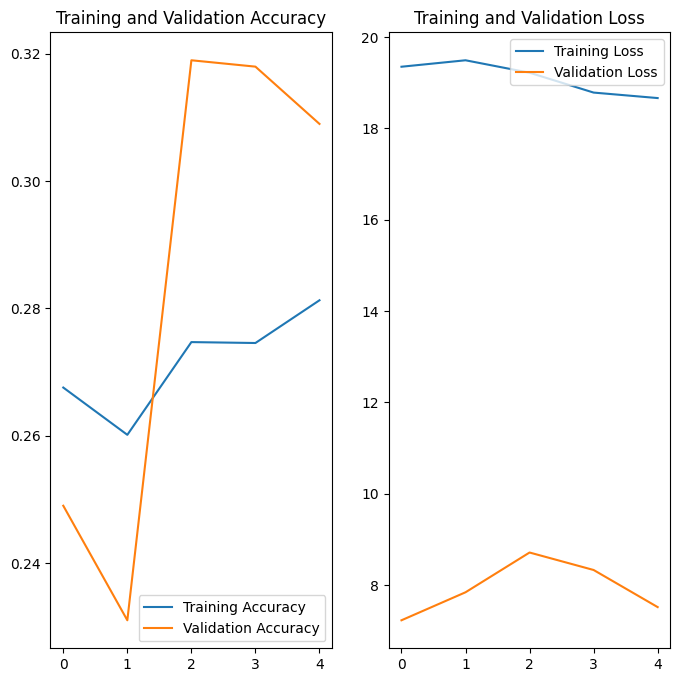

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(val_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Guardamos los datos de Accuracy y Loss

In [70]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 100,200/historycampvec100funcioncosto.csv', index = False)

# Guardamos el modelo

In [67]:
path_to_save = '../../../Modelos/Modelos 100,200'
path_to_save = '../../../Modelos/Modelos 100,200'

In [68]:
model.save(path_to_save + '/campovectorial100funcioncosto.h5')

# Importamos el modelo

In [39]:
new_model = keras.models.load_model('../../../Modelos/Modelos 100,200/campovectorial100funcioncosto.h5', 
                                    custom_objects={'custom_activation': custom_activation, 'custom_loss': custom_loss})

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [55]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos =10

    y1 = np.linspace(x_range_neg, x_range_pos, 100)
    y2 = np.linspace(y_range_neg, y_range_pos, 100)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)

    
campvec = np.array(campvec)
coef = np.array(coef)


--------------------------------------------
[5, 9, 4, 9, 4, 4, 2]


In [56]:
campvecnone = campvec[None, :]

## Predecimos con los datos nuevos

In [57]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 12ms/step
[[4. 4. 6. 5. 5. 4. 6.]]


## Graficamos con los coeficientes reales

Text(0, 0.5, 'Concentración Y')

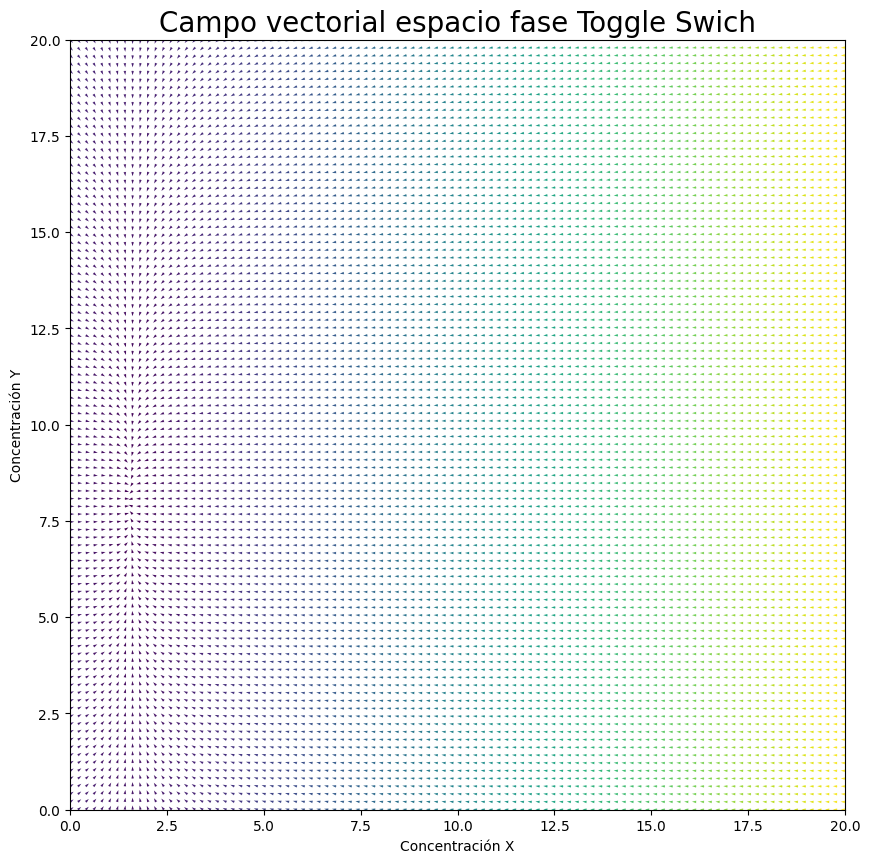

In [43]:
y1 = np.linspace(0, 10, 100)
y2 = np.linspace(0, 10, 100)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

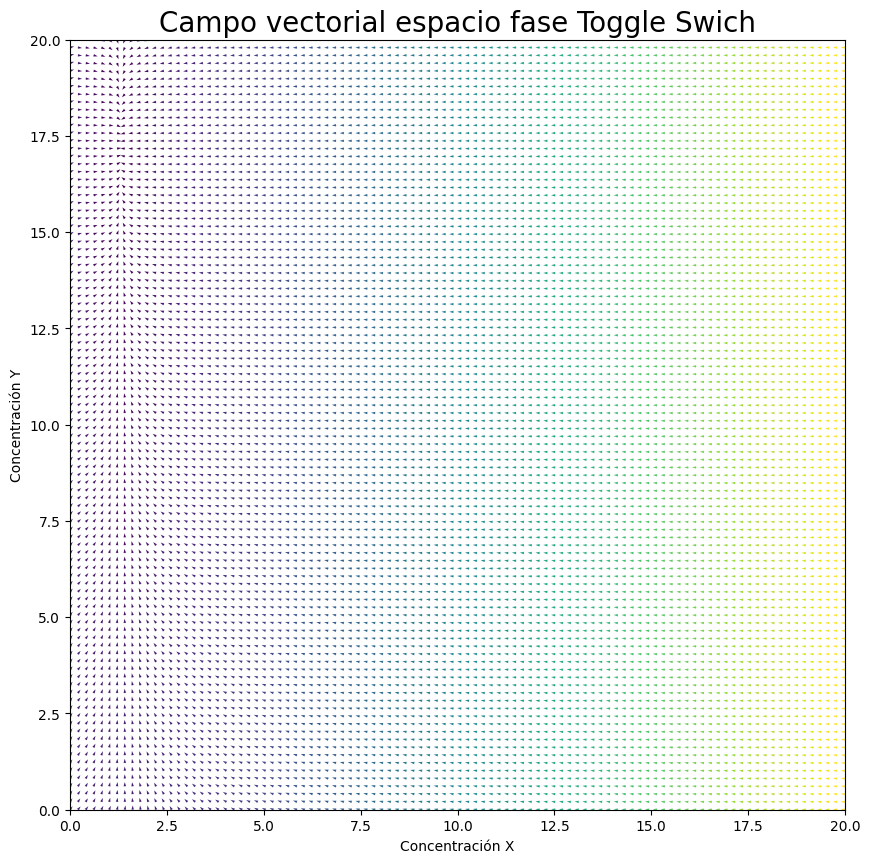

In [45]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]
 
def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1 = np.linspace(x_range_neg, x_range_pos, 100)
y2 = np.linspace(y_range_neg, y_range_pos, 100)

Y1, Y2 = np.meshgrid(y1, y2)
    
t1 = 0

u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

NI, NJ = Y1.shape

u1, v1 = f(t1, [Y1, Y2])
u, v = f(t1, [Y1, Y2])
M = (np.hypot(u, v))
u /= M
v /= M
    
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')